In [2]:
import tensorflow as tf

In [3]:
tf.__version__

'2.0.0'

In [4]:
from tensorflow import keras

# Working with directory library
from os import path, listdir
from os.path import isdir

# Image visualization
import matplotlib.pyplot as plt
%matplotlib inline

import warnings
warnings.filterwarnings('ignore')

In [30]:
# Define function to load image from path, return all image paths and labels.

def load_image_dataset(file_path):
    all_image_dirs = [path.join(file_path, f) for f in listdir(file_path) if not isdir(path.join(file_path, f))]
    all_image_labels = []
    for f in all_image_dirs:
        if f.split('.')[1][-3:] == 'cat':
            all_image_labels.append(0)
        else:
            all_image_labels.append(1)
    return all_image_dirs, all_image_labels

In [31]:
# Load and save image paths and labels

all_image_dirs, all_image_labels = load_image_dataset('./data/train')

In [32]:
# Function that take care of preprocessing image

def preprocess_image(image):
    image = tf.image.decode_jpeg(image, channels=3)
    image = tf.image.resize(image, [192, 192])
    image /= 255.0  # normalize to [0,1] range
    image = 2*image-1  # normalize to [-1,1] range
    return image

def load_and_preprocess_image(path):
    image = tf.io.read_file(path)
    return preprocess_image(image)

def load_and_preprocess_from_path_label(path, label):
    return load_and_preprocess_image(path), label

In [33]:
# Split data to train and test set.

num_train_image = int(len(all_image_labels)*0.8//1)
train_image_dirs, train_label = all_image_dirs[:num_train_image], all_image_labels[:num_train_image]
test_image_dirs, test_label = all_image_dirs[num_train_image:], all_image_labels[num_train_image:]

In [34]:
# Put the image's paths and labels of train and test set to tensorflow dataset.

train_path_label = tf.data.Dataset.from_tensor_slices((train_image_dirs, train_label))
test_path_label = tf.data.Dataset.from_tensor_slices((test_image_dirs, test_label))

In [35]:
# Load and preprocess all the images, put it in the same place with their labels.

train_image_label_ds = train_path_label.map(load_and_preprocess_from_path_label)
test_image_label_ds = test_path_label.map(load_and_preprocess_from_path_label).batch(1)

In [36]:
# implement batch for train set.

BATCH_SIZE = 32
AUTOTUNE = tf.data.experimental.AUTOTUNE

train_ds = train_image_label_ds.shuffle(buffer_size = len(all_image_labels))
train_ds = train_ds.repeat()
train_ds = train_ds.batch(BATCH_SIZE)
train_ds = train_ds.prefetch(buffer_size=AUTOTUNE)

In [13]:
# Create an instance of MobileNetV2 as pre-trained model.

mobile_net = tf.keras.applications.MobileNetV2(input_shape=(192, 192, 3), include_top=False)
mobile_net.trainable=False

9412608/9406464 [==============================] - 28s 3us/step


In [37]:
# Build the CNN-model

cnn_model = keras.models.Sequential([
    mobile_net,
    keras.layers.GlobalAveragePooling2D(),
    keras.layers.Flatten(),
    keras.layers.Dense(64, activation="relu"),
    keras.layers.Dense(2, activation="softmax")
])

In [38]:
cnn_model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
mobilenetv2_1.00_192 (Model) (None, 6, 6, 1280)        2257984   
_________________________________________________________________
global_average_pooling2d_1 ( (None, 1280)              0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 1280)              0         
_________________________________________________________________
dense_2 (Dense)              (None, 64)                81984     
_________________________________________________________________
dense_3 (Dense)              (None, 2)                 130       
Total params: 2,340,098
Trainable params: 82,114
Non-trainable params: 2,257,984
_________________________________________________________________


In [39]:
# Compile CNN-model

cnn_model.compile(optimizer=tf.keras.optimizers.Adam(),
              loss='sparse_categorical_crossentropy',
              metrics=["accuracy"])

In [40]:
# Training the model with the train_ds above.

steps_per_epoch=tf.math.ceil(len(all_image_dirs)/BATCH_SIZE).numpy()
cnn_model.fit(train_ds, epochs=2, steps_per_epoch=steps_per_epoch, validation_data=test_image_label_ds)

Train for 782.0 steps, validate for 5000 steps
Epoch 1/2
782/782 [==============================] - 1730s 2s/step - loss: 0.1296 - accuracy: 0.9485 - val_loss: 0.0796 - val_accuracy: 0.9756
Epoch 2/2
782/782 [==============================] - 1918s 2s/step - loss: 0.0937 - accuracy: 0.9619 - val_loss: 0.1160 - val_accuracy: 0.9628


In [41]:
# save model for flask usage.

cnn_model.save('static/models/dog_cat_TK_2.h5')

In [43]:
import os
checkpoint_path = "static/models/training_1/cp.ckpt"
checkpoint_dir = os.path.dirname(checkpoint_path)

# Create a callback that saves the model's weights
# by default it saves the weights every epoch
cp_callback = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path,
                                                 save_weights_only=True,
                                                 verbose=1)

In [45]:
# Train the model with the new callback
history = cnn_model.fit(train_ds,   
                    epochs=5,
                    steps_per_epoch=steps_per_epoch,
                    validation_data=test_image_label_ds,
                    callbacks=[cp_callback])  # Pass callback to training

Train for 782.0 steps, validate for 5000 steps
Epoch 1/5
781/782 [============================>.] - ETA: 1s - loss: 0.0814 - accuracy: 0.9683
Epoch 00001: saving model to static/models/training_1/cp.ckpt
782/782 [==============================] - 1701s 2s/step - loss: 0.0814 - accuracy: 0.9683 - val_loss: 0.1384 - val_accuracy: 0.9570
Epoch 2/5
781/782 [============================>.] - ETA: 1s - loss: 0.0745 - accuracy: 0.9713
Epoch 00002: saving model to static/models/training_1/cp.ckpt
782/782 [==============================] - 1647s 2s/step - loss: 0.0744 - accuracy: 0.9713 - val_loss: 0.0607 - val_accuracy: 0.9846
Epoch 3/5
781/782 [============================>.] - ETA: 2s - loss: 0.0647 - accuracy: 0.9744
Epoch 00003: saving model to static/models/training_1/cp.ckpt
782/782 [==============================] - 1868s 2s/step - loss: 0.0647 - accuracy: 0.9744 - val_loss: 0.0904 - val_accuracy: 0.9746
Epoch 4/5
781/782 [============================>.] - ETA: 2s - loss: 0.0603 - accur

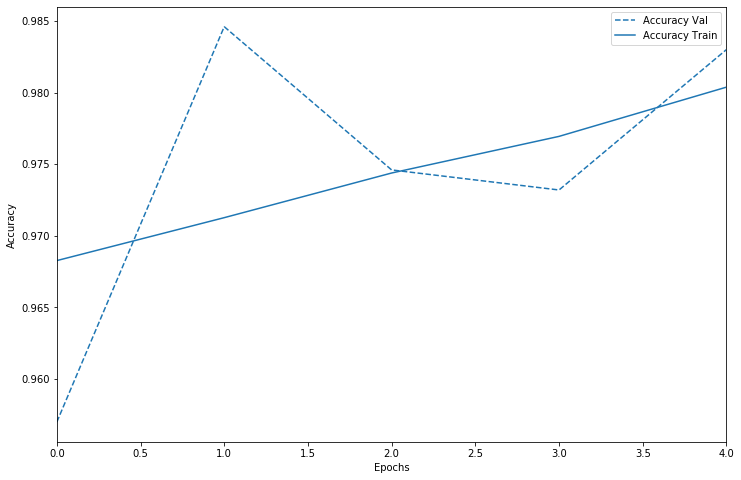

In [46]:
import matplotlib.pyplot as plt

# Visualize model history
def plot_history(history, key='loss'):
    plt.figure(figsize=(12,8))

    val = plt.plot(history.epoch, history.history['val_'+key],
                    '--', label=key.title() +' Val')
    plt.plot(history.epoch, history.history[key], color=val[0].get_color(),
                label=key.title() + ' Train')

    plt.xlabel('Epochs')
    plt.ylabel(key.replace('_',' ').title())
    plt.legend()

    plt.xlim([0,max(history.epoch)])

plot_history(history, key='accuracy')

In [47]:
#Save 2nd model
cnn_model.save('static/models/dog_cat_TK_7.h5')